In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
import time
from sklearn.model_selection import train_test_split
import pandas as pd

import torch
import mlutilities as ml  # for ml.draw
import optimizers as opt  # for opt.sgd, opt.adam, and opt.scg

import neuralnetworks as nn

In [2]:
class NeuralNetworkClassifier(nn.NeuralNetwork):

    # Constructor
    def __init__(self, n_inputs, n_hiddens_list, classes, use_torch=False):

        # Force n_hidens_list to be a list
        
        if not isinstance(n_hiddens_list, list):
            raise Exception('NeuralNetworkClassifier: n_hiddens_list must be a list.')
 
        # Call the constructor for NeuralNetwork, passing in the number of unique class names (ints)
        # as the number of outputs
        
        super().__init__(n_inputs, n_hiddens_list, len(classes), use_torch)

        # Store as member variables other things needed by instances of this class.
        
        self.classes = np.array(classes) # to allow argmax in use()
        
        if use_torch:
            self.log = torch.log
            self.exp = torch.exp
            self.tanh = torch.tanh
        else:
            self.log = np.log
            self.exp = np.exp
            self.tanh = np.tanh
    
    
    def __repr__(self):
        return super().__repr__()
    
    
        
    def _standardizeT(self, T):
        return T
    
    
    def _unstandardizeT(self, T):
        return T
    
    
    def g(self, X):
        fs = np.exp(X)  # N x K
        denom = np.sum(fs, axis=1).reshape((-1,1))
        # pdb.set_trace()
        gs = fs / denom
        # print(gs[:10,:])
        return gs
    
    
    def _forward_pass(self, X):
        # Assume weights already unpacked
        Z_prev = X  # output of previous layer
        Z = [Z_prev]
        for i in range(self.n_hidden_layers):
            V = self.Vs[i]
            Z_prev = self.tanh(Z_prev @ V[1:, :] + V[0:1, :])
            Z.append(Z_prev)
        Y = Z_prev @ self.W[1:, :] + self.W[0:1, :]
        Y=self.g(Y)
        return Y, Z
    
    
    def _objectiveF(self, w, X, T):
        self._unpack(w)
        Y, Z = self._forward_pass(X) 
        #Y = self.g(Y)
        return np.mean(-T * self.log(Y))
    
    
    def _objective_to_actual(self, neg_mean_log_likelihood):
        return self.exp(- neg_mean_log_likelihood)
    
    
    def makeIndicatorVars(self,T):
        # Make sure T is two-dimensiona. Should be nSamples x 1.
        if T.ndim == 1:
            T = T.reshape((-1,1))    
        print(T)
        return (T == np.unique(T)).astype(int)
    
    
    """def _gradientF(self, w, X, T):
        self._unpack(w)
        Y, Z = self._forward_pass(X)
        Y = self.g(Y)
        # Do backward pass, starting with delta in output layer
        delta = -(T - Y) / (X.shape[0] * T.shape[1])
        # Another way to define dEdW without calling np.insert                        
        dW = np.vstack((np.sum(delta, axis=0), Z[-1].T @ delta))
        dVs = []
        delta = (1 - Z[-1]**2) * (delta @ self.W[1:, :].T)
        for Zi in range(self.n_hidden_layers, 0, -1):
            Vi = Zi - 1  # because X is first element of Z
            dV = np.vstack((np.sum(delta, axis=0), Z[Zi-1].T @ delta))
            dVs.insert(0, dV)  # like append, but at front of list of dVs
            delta = (delta @ self.Vs[Vi][1:, :].T) * (1 - Z[Zi-1]**2)
        return self._pack(dVs, dW)"""
    
    
    def train(self, X, T, n_epochs, method='scg',
              verbose=False, save_weights_history=False,
              learning_rate=0.001, momentum_rate=0.0): # only for sgd and adam

        if X.shape[1] != self.n_inputs:
            raise Exception(f'train: number of columns in X ({X.shape[1]}) not equal to number of network inputs ({self.n_inputs})')
        
        if self.use_torch:
            X = torch.tensor(X, dtype=torch.float)  # 32 bit
            T = torch.tensor(T, dtype=torch.float)
        
        T = self.makeIndicatorVars(T)
        self._setup_standardize(X, T)
        X = self._standardizeX(X)
        T = self._standardizeT(T)
        
        try:
            algo = [opt.sgd, opt.adam, opt.scg][['sgd', 'adam', 'scg'].index(method)]
        except:
            raise Exception("train: method={method} not one of 'scg', 'sgd' or 'adam'")            

        result = algo(super()._pack(self.Vs, self.W),
                      self._objectiveF,
                      [X, T], n_epochs,
                      super()._gradientF,  # not used if scg
                      eval_f=self._objective_to_actual,
                      learning_rate=learning_rate, momentum_rate=momentum_rate,
                      verbose=verbose, use_torch=self.use_torch,
                      save_wtrace=save_weights_history)

        self._unpack(result['w'])
        self.reason = result['reason']
        self.error_trace = result['ftrace'] # * self.Tstds # to _unstandardize the MSEs
        self.n_epochs = len(self.error_trace) - 1
        self.trained = True
        self.weight_history = result['wtrace'] if save_weights_history else None
        self.training_time = result['time']
        return self
    
    def use(self, X, all_outputs=False):
        if self.use_torch:
            if not isinstance(X, torch.Tensor):
                X = torch.tensor(X, dtype=torch.float)
        X = self._standardizeX(X)
        Y, Z = self._forward_pass(X)
        Y = self._unstandardizeT(Y)
        #gs = self.g(Y)
        if self.use_torch:
            Y = Y.detach().cpu().numpy()
            Z = [Zi.detach().cpu().numpy() for Zi in Z]
       
        Y_classes = Y.copy()
        
        maxindex = []
        for row in Y_classes:
            maxindex.append(row.argmax())
        for row in range(Y_classes.shape[0]):
            Y_classes[row][maxindex[row]] = 1
        for j in range(Y_classes.shape[1]):
            for i in range(Y_classes.shape[0]):
                if Y_classes[i][j] != 1:
                    Y_classes[i][j] = 0
        Yclass=[0]*len(Y_classes)
        for i in range(len(Y_classes)):
            for j in range(Y_classes.shape[1]):
                if Y_classes[i][j]==1:
                    Yclass[i]=self.classes[j]
        Yclass=np.array(Yclass).reshape(-1,1)
        return (Yclass, Y, Z[1:]) if all_outputs else (Yclass, Y)

In [3]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

n_samples = 20
X = np.random.choice(3, (n_samples, 2))
T = (X[:, 0:1] == X[:, 1:2]).astype(int)  # where the two inputs are equal
classes = [0, 1]

for x, t in zip(X, T):
    print(f'x = {x}, t = {t}')

x = [2 0], t = [0]
x = [2 2], t = [1]
x = [0 0], t = [1]
x = [2 1], t = [0]
x = [2 2], t = [1]
x = [2 2], t = [1]
x = [0 2], t = [0]
x = [1 0], t = [0]
x = [1 1], t = [1]
x = [1 1], t = [1]
x = [0 0], t = [1]
x = [1 1], t = [1]
x = [0 0], t = [1]
x = [0 2], t = [0]
x = [2 2], t = [1]
x = [1 2], t = [0]
x = [1 1], t = [1]
x = [2 1], t = [0]
x = [2 2], t = [1]
x = [0 2], t = [0]


In [4]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet_new = NeuralNetworkClassifier(2, [10, 10], [0, 1])
nnet_new


NeuralNetworkClassifier(2, [10, 10], 2, use_torch=False)  Network is not trained.

In [5]:
nnet_new._standardizeT(T)

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

In [6]:
nnet_new._unstandardizeT(T)

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

In [7]:
nnet_new._setup_standardize(X, T)
Xst = nnet_new._standardizeX(X)
Xst

array([[ 1.08347268, -1.47709789],
       [ 1.08347268,  0.98473193],
       [-1.32424438, -1.47709789],
       [ 1.08347268, -0.24618298],
       [ 1.08347268,  0.98473193],
       [ 1.08347268,  0.98473193],
       [-1.32424438,  0.98473193],
       [-0.12038585, -1.47709789],
       [-0.12038585, -0.24618298],
       [-0.12038585, -0.24618298],
       [-1.32424438, -1.47709789],
       [-0.12038585, -0.24618298],
       [-1.32424438, -1.47709789],
       [-1.32424438,  0.98473193],
       [ 1.08347268,  0.98473193],
       [-0.12038585,  0.98473193],
       [-0.12038585, -0.24618298],
       [ 1.08347268, -0.24618298],
       [ 1.08347268,  0.98473193],
       [-1.32424438,  0.98473193]])

In [8]:
Y, Z = nnet_new._forward_pass(Xst)
Y

array([[0.55163905, 0.44836095],
       [0.52855705, 0.47144295],
       [0.59590952, 0.40409048],
       [0.5358871 , 0.4641129 ],
       [0.52855705, 0.47144295],
       [0.52855705, 0.47144295],
       [0.59746461, 0.40253539],
       [0.57163885, 0.42836115],
       [0.56395347, 0.43604653],
       [0.56395347, 0.43604653],
       [0.59590952, 0.40409048],
       [0.56395347, 0.43604653],
       [0.59590952, 0.40409048],
       [0.59746461, 0.40253539],
       [0.52855705, 0.47144295],
       [0.56007003, 0.43992997],
       [0.56395347, 0.43604653],
       [0.5358871 , 0.4641129 ],
       [0.52855705, 0.47144295],
       [0.59746461, 0.40253539]])

In [9]:
w = nnet_new._pack(nnet_new.Vs, nnet_new.W)

T_indicator_vars = np.hstack((1 - T, T))  # this only works for this particular two-class toy data

nnet_new._objectiveF(w, X, T_indicator_vars)

0.3525328777771416

In [10]:
nnet_new.train(X, T, 100)

[[0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]]


NeuralNetworkClassifier(2, [10, 10], 2, use_torch=False)
   Network was trained for 66 epochs that took 0.0326 seconds. Final objective value is 1.000

In [11]:
Yclass, Y = nnet_new.use(X)
print(Y)
print(Yclass)

            
            


[[9.99999997e-01 3.20093994e-09]
 [1.54701892e-09 9.99999998e-01]
 [9.32353023e-10 9.99999999e-01]
 [9.99999982e-01 1.80001615e-08]
 [1.54701892e-09 9.99999998e-01]
 [1.54701892e-09 9.99999998e-01]
 [9.99999993e-01 7.37368103e-09]
 [9.99999981e-01 1.86568644e-08]
 [4.81008263e-09 9.99999995e-01]
 [4.81008263e-09 9.99999995e-01]
 [9.32353023e-10 9.99999999e-01]
 [4.81008263e-09 9.99999995e-01]
 [9.32353023e-10 9.99999999e-01]
 [9.99999993e-01 7.37368103e-09]
 [1.54701892e-09 9.99999998e-01]
 [9.99999977e-01 2.32123629e-08]
 [4.81008263e-09 9.99999995e-01]
 [9.99999982e-01 1.80001615e-08]
 [1.54701892e-09 9.99999998e-01]
 [9.99999993e-01 7.37368103e-09]]
[[0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]]


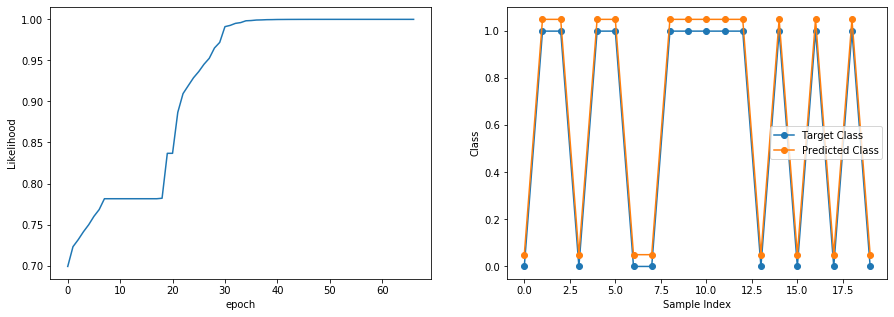

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Yclass + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

# Training and Testing with Iris dataset 

In [13]:
from sklearn import datasets
iris = datasets.load_iris()


In [14]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [15]:
X=iris.data[:,:]
T=iris.target

In [16]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [17]:
convert = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
}
for i in range(Y.shape[0]):
    Y[i] = convert[Y[i]]

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
Y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, T, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
np.random.seed(42)
nnet = NeuralNetworkClassifier(4, [5,6,6,7], [0, 1, 2])
nnet

In [ ]:
y_train

In [ ]:
nnet._standardizeT(y_train)
#X_train=np.array(X_train)
#y_train=np.array(y_train).reshape(-1,1)

In [ ]:
nnet._unstandardizeT(y_train)

In [ ]:
nnet.train(X_train ,y_train, 100)

In [ ]:
Y_classes, Y = nnet.use(X_train)

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(nnet.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(y_train, 'o-')
plt.plot(Y_classes, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

In [ ]:
Y_classes, Y = nnet.use(X_test)
Y_classes.shape, Y.shape

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(nnet.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(y_test, 'o-')
plt.plot(Y_classes, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

In [ ]:
for iterations in [100, 200, 500, 1000, 2000]:
    
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)

    
    nnet.train(X_train, y_train, iterations)
    Y_classes, Y = nnet.use(X_test, False)
    Y_classes = np.array(Y_classes).reshape(-1,1)
    Y = np.array(Y)
    n_correct = (Y_classes == y_test).sum()
    print(f'Training data: {n_correct} out of {y_test.shape[0]} samples, or {n_correct/y_test.shape[0]*100:.2f} percent in {iterations} iterations')

The accuracy seems to go down with increased number of iterations. 

In [ ]:
%run -i A3grader.py